In [1]:
# %%
import ot
import numpy as np
import otmol as otm
import pandas as pd
from openbabel import pybel
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import os
# %matplotlib widget

In [8]:
def RMSD(V, W):
    """ 
    Calculate Root-mean-square deviation from two sets of vectors V and W.
    """
    N = V.shape[0]
    return np.sqrt(np.sum((V-W)**2)/N)

def compare_lists(list1, list2):
    """
    Compare two lists and return the indices and elements where they differ.

    Args:
        list1 (list): The first list to compare.
        list2 (list): The second list to compare.

    Returns:
        list: A list of tuples, where each tuple contains the index and the differing elements
              in the format (index, element_from_list1, element_from_list2).
    """
    differences = []
    # Compare elements up to the length of the shorter list
    for i in range(len(list1)):
        if list1[i] != list2[i]:
            differences.append((i, list1[i], list2[i]))

    return differences

def parse_molecule_pairs(file_path, mol_type: str = 'water cluster'):
    """
    Parses a file containing molecule pairs separated by an underscore ('_').

    Parameters:
    ----------
    file_path : str
        Path to the file containing molecule pairs.

    Returns:
    -------
    list of lists
        A list where each element is a pair [molA, molB].
    """
    molecule_pairs = []
    with open(file_path, 'r') as file:
        if mol_type == 'water cluster' or mol_type == 'S1':
            for line in file:
                line = line.strip()  # Remove any leading/trailing whitespace
                if line:  # Skip empty lines
                    # Some lines are like "molA_molB_2", and some are like "molA_molB"
                    molecule_pairs.append([line.split('_')[0], line.split('_')[1]])
        if mol_type == 'FGG':
            next(file)  # Skip the first line
            for line in file:
                line = line.strip()
                if line:
                    molA, molB = line.split('-')
                    molecule_pairs.append([molA, molB])
    return molecule_pairs

def is_wc_permutation(A):
    """
    Check if the given 1D numpy array satisfies the condition:
    After grouping every 3 integers, sorting each group in ascending order
    results in [min(group), min(group)+1, min(group)+2].

    Args:
        A (numpy.ndarray): A 1D numpy array of integers.

    Returns:
        bool: True if all groups satisfy the condition, False otherwise.
    """
    if len(np.unique(A)) != len(A):
        print('Warning: not a proper assignment for water clusters')
    n = len(A)
    if n % 3 != 0:
        raise ValueError("The length of the array must be a multiple of 3.")
    
    groups = [A[i:i+3] for i in range(0, n, 3)]  # Group every 3 integers
    for group in groups:
        sorted_group = sorted(group)
        if sorted_group != [np.min(group), np.min(group) + 1, np.min(group) + 2]:
            #print('Warning: not a proper assignment for water clusters')
            return False
    return True

def parse_and_permute_xyz(xyz_file, permutation):
    """
    Parse an XYZ file, permute the water molecules, and return a list of coordinates
    with O atoms always listed before H atoms in each water molecule.

    Args:
        xyz_file (str): Path to the input XYZ file.
        permutation (list): A list of integers representing the new order of water molecules.

    Returns:
        list: A list of coordinates for the permuted water molecules.
    """
    with open(xyz_file, 'r') as file:
        lines = file.readlines()

    # Read the number of atoms and the comment line
    num_atoms = int(lines[0].strip())
    comment = lines[1].strip()

    # Ensure the number of atoms is divisible by 3 (for water molecules)
    if num_atoms % 3 != 0:
        raise ValueError("The number of atoms in the XYZ file is not divisible by 3.")

    # Group atoms into water molecules (3 atoms per molecule)
    molecules = [lines[i:i+3] for i in range(2, len(lines), 3)]

    # Reorder the molecules based on the permutation
    permuted_molecules = [molecules[i] for i in permutation]

    # Ensure O atom is listed before H atoms in each molecule
    sorted_molecules = []
    for molecule in permuted_molecules:
        # Sort the atoms in the molecule: O first, then H
        sorted_molecule = sorted(molecule, key=lambda line: line.split()[0] == 'H')
        sorted_molecules.append(sorted_molecule)

    # Extract coordinates from the sorted and permuted molecules
    coordinates = []
    for molecule in sorted_molecules:
        for atom_line in molecule:
            parts = atom_line.split()
            coordinates.append([float(parts[1]), float(parts[2]), float(parts[3])])

    return np.array(coordinates, dtype=float)

def wc_D(X_A):
    D_A = np.ones((X_A.shape[0], X_A.shape[0]))*10
    for i in range(0, X_A.shape[0], 3):
        D_A[i:i+3, i:i+3] = distance_matrix(X_A[i:i+3], X_A[i:i+3])
    return D_A



In [12]:
def Experiment(data_path: str = None,mol_pair: list = None, method: str = 'fgw', 
               alpha_list: list = None, D_matrix: str = 'geodesic', p_list: list = None,
               ):
    """
    Experiment with ArbAlign data.
    """
    results = []
    # Load the molecule pairs from the specified file
    for nameA, nameB in mol_pair:
        molA = next(pybel.readfile('xyz', os.path.join(data_path, nameA + '.xyz')))
        molB = next(pybel.readfile('xyz', os.path.join(data_path, nameB + '.xyz')))
        # Basic processing of the molecules
        #X_A, T_A, B_A = otm.tl.process_molecule(molA) # Output (1) spatial coordinates, (2) atom types, and (3) bonds as numpy arrays.
        #X_B, T_B, B_B = otm.tl.process_molecule(molB)
        X_A = parse_and_permute_xyz(os.path.join(data_path, nameA + '.xyz'), np.array(np.arange(len(molA.atoms)/3), dtype=int)) # just reorder atoms inside each water molecule to O H H
        X_B = parse_and_permute_xyz(os.path.join(data_path, nameB + '.xyz'), np.array(np.arange(len(molB.atoms)/3), dtype=int)) 
        T_A, T_B = np.array(['O', 'H', 'H']*int(X_A.shape[0]/3), dtype=str), np.array(['O', 'H', 'H']*int(X_B.shape[0]/3), dtype=str)
        C = otm.tl.molecule_physchem_distance(T_A, T_B) 
        C = np.where(C>0, 1e11, C) # this makes O to O, H to H
        #D_A = wc_D(X_A)
        #D_B = wc_D(X_B)
        D_A = distance_matrix(X_A, X_A)
        D_B = distance_matrix(X_B, X_B)
        rmsd_best = 1e10
        p_best = None
        P_best = None
        alpha_best = None
        for alpha in alpha_list:
            for p in p_list:
                P = otm.tl.molecule_optimal_transport(C, D_A**p, D_B**p, method='fgw', alpha=alpha)
                X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P)
                D_ot = np.ones((X_A.shape[0], X_B.shape[0]), dtype=float)*1e6
                for i in range(0, X_A.shape[0], 3): 
                    # this is trying to construct a distance matrix such that one water molecule is mapped to another
                    # according to P, based on newly aligned X_B
                    j = np.argmax(P[i])
                    D_ot[i, j] = 0. # O to O
                    D_ot[i+1:i+3, j+1:j+3] = distance_matrix(X_A[i+1:i+3], X_B_aligned[j+1:j+3]) # H to H
                P_ot = ot.emd(np.ones([X_A.shape[0]])/X_A.shape[0], np.ones([X_B.shape[0]])/X_B.shape[0], D_ot)
                X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P_ot)
                rmsd_ot = RMSD(X_A, X_B_aligned[np.argmax(P_ot, axis=1)])
                if rmsd_ot < rmsd_best:
                    rmsd_best = rmsd_ot
                    p_best = p
                    P_best = P_ot
                    alpha_best = alpha
        optimal_assignment = np.argmax(P_best, axis=1)

        if len(np.unique(optimal_assignment)) != X_A.shape[0]: # check if the assignment is 1 to 1
            print(nameA, nameB, 'Warning: the assignment is not 1 to 1')
        if not is_wc_permutation(optimal_assignment):
            print(nameA, nameB, 'Warning: the assignment is not a water cluster permutation')
        if compare_lists(T_A, T_B[optimal_assignment]): # check if atom names are matched. We have matched T_B with T_A by parse_and_permute_xyz()
            print(nameA, nameB, 'Warning: unmatched atom names exist')
        results.append({
            'nameA': nameA,
            'nameB': nameB,
            'RMSD(otmol)': rmsd_best,
            '# atoms': X_A.shape[0],
            'alpha': alpha_best,
            'p': p_best,
            'assignment': optimal_assignment,
            'atomname_diff': compare_lists(T_A, T_B[optimal_assignment])
        }) 
        print(nameA, nameB, rmsd_best)

    return pd.DataFrame(results)

In [15]:
data_path = "./DataArbAlign/Water-Clusters"
#data_path = "./DataArbAlign/FGG"
mol_pair_list_path = os.path.join(data_path, 'list')
molecule_pairs = parse_molecule_pairs(mol_pair_list_path, mol_type='water cluster')
otmol_res = Experiment(data_path, molecule_pairs, method='fgw', D_matrix='euclidean', alpha_list=np.linspace(0,0.05,500), p_list=[0.5, 1, 2])
#print(otmol_res)

2-Cs-1 2-OpenC1 0.3156795628351815
3-UUD 3-UUU 0.30954362705566146
4-Ci 4-S4 0.4939862594397266
5-CA-A 5-CA-B 0.7561391920617176
6-BAG 6-BK-1 1.1502133153139573
7-BI1 7-BI2 0.4504250872530827
8-D2d 8-S4 0.6063086293512906
9-D2dDD 9-S4DA 0.6406989561890261
10-PP1 10-PP2 0.6384402177196827
11-551A-1 11-551A-4 0.13688867337895683
12-D2d-1-L 12-D2d-1-R 0.5141389955096731
13-TIP4P 13-TIP5P 1.2281648589693068
14-1 14-2 0.5519288333105364
15-1 15-2 1.1779323886945785
16-TIP4P 16-TIP5P 1.6074334831759118
17-TIP4P 17-TIP5P 1.2084151315488811
18-TIP4P 18-TIP5P 1.5565872691988984
19-TIP4P 19-TIP5P 1.4348133122964202
20-TIP4P 20-TIP5P 1.894483829949143
21-TIP4P 21-TIP5P 1.522313964550906
25-1 25-2 0.9644411634818141
40-a 40-b 2.3312547729846917
60-1 60-2 2.1471953545080864
100-1 100-2 2.12646181977701


In [16]:
otmol_res

,nameA,nameB,RMSD(otmol),# atoms,alpha,p,assignment,atomname_diff
0,2-Cs-1,2-OpenC1,0.315680,6,0.000100,1.0,"[0, 2, 1, 3, 4, 5]",[]
1,3-UUD,3-UUU,0.309544,9,0.000100,1.0,"[0, 2, 1, 6, 8, 7, 3, 4, 5]",[]
2,4-Ci,4-S4,0.493986,12,0.002906,2.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",[]
3,5-CA-A,5-CA-B,0.756139,15,0.014930,0.5,"[9, 10, 11, 12, 14, 13, 0, 2, 1, 3, 4, 5, 6, 7...",[]
4,6-BAG,6-BK-1,1.150213,18,0.004208,1.0,"[15, 17, 16, 6, 8, 7, 12, 14, 13, 0, 1, 2, 9, ...",[]
5,7-BI1,7-BI2,0.450425,21,0.000501,1.0,"[9, 10, 11, 6, 7, 8, 0, 1, 2, 15, 16, 17, 3, 4...",[]
6,8-D2d,8-S4,0.606309,24,0.001403,2.0,"[15, 16, 17, 6, 7, 8, 18, 20, 19, 21, 22, 23, ...",[]
7,9-D2dDD,9-S4DA,0.640699,27,0.000100,1.0,"[18, 19, 20, 21, 22, 23, 15, 17, 16, 24, 26, 2...",[]
8,10-PP1,10-PP2,0.638440,30,0.002104,2.0,"[3, 5, 4, 6, 7, 8, 18, 20, 19, 12, 13, 14, 15,...",[]
9,11-551A-1,11-551A-4,0.136889,33,0.000100,1.0,"[15, 16, 17, 27, 29, 28, 6, 8, 7, 21, 22, 23, ...",[]


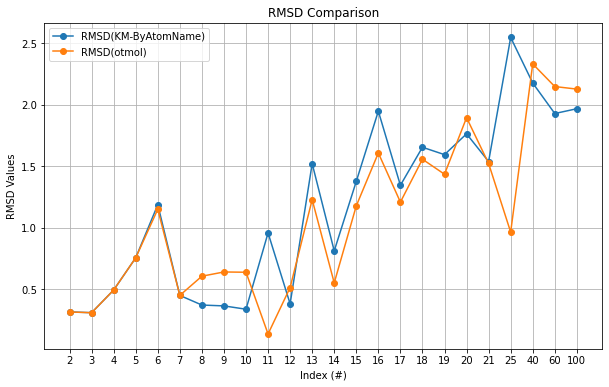

In [17]:
# Concatenate otmol_res and df along the columns
arbalign_res = pd.read_csv(os.path.join(data_path, 'rmsd-2017.dat'), sep='\s+')

combined_df = pd.concat([otmol_res, arbalign_res], axis=1)

# Plot the specified columns against the uniform index
columns_to_plot = ["RMSD(KM-ByAtomName)", "RMSD(otmol)"]

plt.figure(figsize=(10, 6))
# Plot each column against the uniform index
for column in columns_to_plot:
    plt.plot(range(len(combined_df['#'])), combined_df[column], marker='o', label=column)

# Update the x-axis ticks to show the actual values in the '#' column
plt.xticks(range(len(combined_df['#'])), combined_df['#'])

plt.title("RMSD Comparison")
plt.xlabel("Index (#)")  # Reflect the '#' column in the label
plt.ylabel("RMSD Values")
plt.legend()
plt.grid(True)

0.6384402177196827
[]


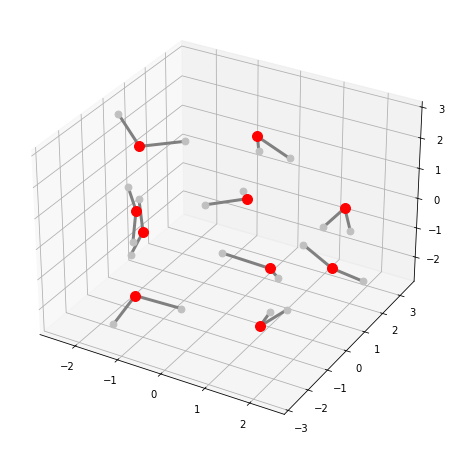

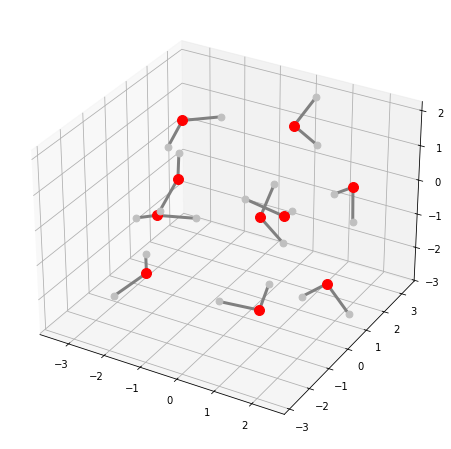

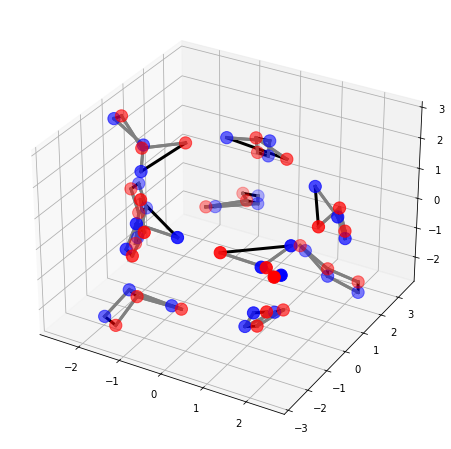

In [131]:
# %%
# Read the molecules
molA = next(pybel.readfile("xyz", "./DataArbAlign/Water-Clusters/10-PP1.xyz"))
molB = next(pybel.readfile("xyz", "./DataArbAlign/Water-CLusters/10-PP2.xyz"))
def permutation_to_matrix(permutation):
    """
    Converts a permutation list to a permutation matrix.
    
    Args:
        permutation (list or array): A list or array representing the permutation.
                                     For example, [2, 0, 1] means index 0 maps to 2, index 1 maps to 0, etc.
    
    Returns:
        numpy.ndarray: A permutation matrix.
    """
    n = len(permutation)
    matrix = np.zeros((n, n), dtype=int)
    for i, j in enumerate(permutation):
        matrix[i, j] = 1
    return matrix
# Basic processing of the molecules
X_A, T_A, B_A = otm.tl.process_molecule(molA) # Output (1) spatial coordinates, (2) atom types, and (3) bonds as numpy arrays.
X_B, T_B, B_B = otm.tl.process_molecule(molB)
otm.pl.plot_molecule(X_A, T_A, B_A, coloring = 'type', sizing = 'type')
otm.pl.plot_molecule(X_B, T_B, B_B, coloring = 'type', sizing = 'type')
P = permutation_to_matrix(otmol_res['assignment'][8])
X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P) 
print(RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)]))
#print(T_A)
#print(T_B[np.argmax(P, axis=1)])
print(compare_lists(T_A, T_B[np.argmax(P, axis=1)]))
otm.pl.plot_alignment(X_A, X_B_aligned, B_A, B_B, P, weight_cutoff=0.01)
plt.show()

In [58]:
# Basic processing of the molecules
def wc_D(X_A):
    D_A = np.ones((X_A.shape[0], X_A.shape[0]))*1e6
    for i in range(0, X_A.shape[0], 3):
        D_A[i:i+3, i:i+3] = distance_matrix(X_A[i:i+3], X_A[i:i+3])
    return D_A
#D_A = wc_D(X_A[:6])
#D_B = wc_D(X_B[:6])
#print(D_A)

In [57]:
#print(distance_matrix(X_A[:6], X_A[:6]))

In [109]:
molA = next(pybel.readfile("xyz", "./DataArbAlign/Water-Clusters/12-D2d-1-L.xyz"))
molB = next(pybel.readfile("xyz", "./DataArbAlign/Water-CLusters/12-D2d-1-R.xyz"))
X_A, T_A, B_A = otm.tl.process_molecule(molA) # Output (1) spatial coordinates, (2) atom types, and (3) bonds as numpy arrays.
X_B, T_B, B_B = otm.tl.process_molecule(molB)
C = otm.tl.molecule_physchem_distance(T_A, T_B)
C = np.where(C>0, 1e12, C)
D_A = distance_matrix(X_A, X_A)
D_B = distance_matrix(X_B, X_B)
#D_A = wc_D(X_A)
#D_B = wc_D(X_B)
alpha_list = np.linspace(0, 0.1, 1000)
p_list = [1]
rmsd_best = 1e10
p_best = None
P_best = None
alpha_best = None
for alpha in alpha_list:
    for p in p_list:
        P = otm.tl.molecule_optimal_transport(C, D_A**p, D_B**p, method='fgw', alpha=alpha)
        X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P)
        D_ot = np.ones((X_A.shape[0], X_A.shape[0]), dtype=float)*1e6
        for i in range(0, X_A.shape[0], 3):
            j = np.argmax(P[i])
            D_ot[i, j] = 0.
            D_ot[i+1:i+3, j+1:j+3] = distance_matrix(X_A[i+1:i+3], X_B_aligned[j+1:j+3])
            #distance_matrix(X_A[i:i+3], X_B_aligned[j:j+3])
        P_ot = ot.emd(np.ones([X_A.shape[0]])/X_A.shape[0], np.ones([X_B.shape[0]])/X_B.shape[0], D_ot)
        X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P_ot)
        rmsd_ot = RMSD(X_A, X_B_aligned[np.argmax(P_ot, axis=1)])
        if rmsd_ot < rmsd_best:
            rmsd_best = rmsd_ot
            p_best = p
            P_best = P_ot
            alpha_best = alpha
optimal_assignment = np.argmax(P_best, axis=1)
#X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P_ot) 
print(rmsd_best)
is_wc_permutation(np.argmax(P_best, axis=1))
if compare_lists(T_A, T_B[optimal_assignment]): # check if atom names are matched. We have matched T_B with T_A by parse_and_permute_xyz()
    print('Warning: unmatched atom names exist')
plt.show()

0.5141389955096731


In [105]:
print(np.argmax(P_best, axis=1))

[ 5  4  3 26 24 25  8  6  7 12 13 14 27 29 28 16 17 15 21 22 23 32 30 31
 36 37 38  0  2  1 35 33 34 11 10  9 18 19 20]


In [103]:
print(compare_lists(T_A, T_B[optimal_assignment]))

[(0, 'O', 'H'), (2, 'H', 'O'), (6, 'O', 'H'), (8, 'H', 'O'), (21, 'O', 'H'), (23, 'H', 'O'), (30, 'O', 'H'), (31, 'H', 'O'), (33, 'O', 'H'), (35, 'H', 'O')]


In [93]:
print(D_ot[:6, :6])

[[3.86416816e+00 3.98282184e+00 3.71202235e+00 1.00000000e+06
  1.00000000e+06 1.00000000e+06]
 [3.71906134e+00 3.60905448e+00 3.67924659e+00 1.00000000e+06
  1.00000000e+06 1.00000000e+06]
 [3.37900705e+00 3.59275180e+00 3.02897484e+00 1.00000000e+06
  1.00000000e+06 1.00000000e+06]
 [1.00000000e+06 1.00000000e+06 1.00000000e+06 1.26791290e+00
  1.56296146e+00 4.75895131e-01]
 [1.00000000e+06 1.00000000e+06 1.00000000e+06 1.65910359e+00
  1.44239409e+00 1.33943188e+00]
 [1.00000000e+06 1.00000000e+06 1.00000000e+06 8.88707003e-01
  1.62721652e+00 7.07287591e-01]]
